### **Instalando e importando las librerías necesarias**

In [ ]:
import sys
!{sys.executable} -m pip install pyserial times numpy pandas xlsxwriter matplotlib sklearn deap

In [2]:
import serial
from time import time
import numpy as np
import pandas as pd
import xlsxwriter
import matplotlib.pyplot as plt

### **Almacenamiento de datos en memoria y creación de la hoja de cálculo**

In [52]:
ser = serial.Serial('/dev/ttyUSB0', 9600) # Configuración del puerto serial

# Vector para valores entre 0 y 255
inputData = []
# Vector para valores de velocidad (rad/s)
outputData = [] 

# Número de muestras requeridas
data_lenght = 250
# Variable para almacenar la longitud de outputData
L = 0

# Tirar datos basura en el serial buffer
ser.flushInput()

while L < data_lenght:
    ser.reset_input_buffer()
    
    # Leer valor actual del puerto serial
    data = ser.readline().decode("utf-8").split(' ')
    
    # Agregar los valores muestreados a inputData y outputData
    try:
        inputData.append(float(data[0]))
        outputData.append(float(data[1]))
    
    except: pass
    
    # Actualizar variable L
    L = len(outputData)
    print(L)

# Cerrar puerto serial
ser.close()

# Creación de la hoja de cálculo a partir de inputData y outputData
workbook = xlsxwriter.Workbook('motor-ZN.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'time')
worksheet.write('B1', 'u')
worksheet.write('C1', 'y')

k  = 1
Ts = 0.22848

for entry, output in zip(inputData, outputData):
    worksheet.write(k, 0, Ts * k)
    worksheet.write(k, 1, entry)
    worksheet.write(k, 2, output)
    k += 1
    
workbook.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


### **Generación de los conjuntos de entrada X e Y**

In [5]:
x = pd.read_excel('motor-new.xlsx')
x = x.drop('time', axis=1)
L = len(x)

# Columnas u(k-1) y y(k-1)
q1 = pd.DataFrame()
q1['u1'] = pd.Series(x['u'], index=x.index)
q1['y1'] = pd.Series(x['y'], index=x.index)
q1 = q1.shift(periods=-1, freq=None, axis=0)

x['u1'] = pd.Series(q1['u1'], index=x.index)
x['y1'] = pd.Series(q1['y1'], index=x.index)

# Columnas u(k-2) y y(k-2)
q2 = pd.DataFrame()
q2['u2'] = pd.Series(x['u'], index=x.index)
q2['y2'] = pd.Series(x['y'], index=x.index)
q2 = q2.shift(periods=-2, freq=None, axis=0)

x['u2'] = pd.Series(q2['u2'], index=x.index)
x['y2'] = pd.Series(q2['y2'], index=x.index)
'''
# Columnas u(k-3) y y(k-3)
q3 = pd.DataFrame()
q3['u3'] = pd.Series(x['u'], index=x.index)
q3['y3'] = pd.Series(x['y'], index=x.index)
q3 = q3.shift(periods=-3, freq=None, axis=0)

x['u3'] = pd.Series(q3['u3'], index=x.index)
x['y3'] = pd.Series(q3['y3'], index=x.index)

# Columnas u(k-4) y y(k-4)
q4 = pd.DataFrame()
q4['u4'] = pd.Series(x['u'], index=x.index)
q4['y4'] = pd.Series(x['y'], index=x.index)
q4 = q4.shift(periods=-4, freq=None, axis=0)

x['u4'] = pd.Series(q4['u4'], index=x.index)
x['y4'] = pd.Series(q4['y4'], index=x.index)
'''
x = x.drop(x.index[L-2:L])

y = pd.DataFrame()
y['y'] = x['y'] # Conjunto Y listo

x = x.drop('y', axis=1) # Conjunto x listo

In [6]:
max(y['y'])

235.17

### **Entrenamiento y prueba del modelo**

In [7]:
from sklearn.model_selection import train_test_split

# Separando los conjuntos de entrada: 60% para entrenamiento y 40% para test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)

In [8]:
from sklearn.linear_model import ElasticNet

# Instanciando el modelo
model = ElasticNet()

In [9]:
# Entrenamiento del modelo
model.fit(x_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [10]:
# Porcentaje de ajuste del modelo sobre el conjunto de test
model.score(x_test,y_test)

0.9994056791381679

([array([ 595.,  520.,  413.,  374.,  435.,  526.,  696., 1132., 2042.,
         1267.]),
  array([ 589.,  527.,  406.,  381.,  441.,  535.,  694., 1130., 1973.,
         1324.])],
 array([ -8.71526866,  15.80611209,  40.32749284,  64.84887358,
         89.37025433, 113.89163508, 138.41301583, 162.93439657,
        187.45577732, 211.97715807, 236.49853882]),
 <a list of 2 Lists of Patches objects>)

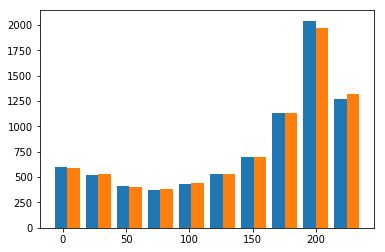

In [11]:
# Inspección visual como una de las medidas para prevenir sobre ajuste
predicted = model.predict(x_test)
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([predicted, y_test['y']])

In [12]:
x

,u,u1,y1,u2,y2
0,143,143.0,187.18,143.0,188.12
1,143,143.0,188.12,143.0,188.97
2,143,143.0,188.97,143.0,189.69
3,143,143.0,189.69,143.0,190.28
4,143,143.0,190.28,143.0,190.85
5,143,143.0,190.85,143.0,191.36
6,143,143.0,191.36,143.0,191.78
7,143,143.0,191.78,143.0,192.13
8,143,143.0,192.13,142.0,192.13
9,143,142.0,192.13,142.0,192.40


### **Sintonización del controlador mediante algoritmos genéticos**

In [13]:
from deap import base, creator

# Configuración para buscar controladores que minimizen el error
creator.create("ControllerFitness", base.Fitness, weights=(-1.0,))
# Creación de la clase para crear individuos (cromosomas)
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [14]:
import random
from deap import tools

# ki bits + kp bits + kd bits
IND_SIZE = 33

# Configuración de los individuos como palabras binarias
toolbox = base.Toolbox()
toolbox.register("bit_attribute", random.randint, 0, 1)
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

### **Evaluación de la performance del controlador decodificado**

In [42]:
def evaluate(individuo):
    
    # =================== Decodificación de individuo ===================
    controller = ''.join(map(str,individuo))
    
    # Palabra digitales
    _kp = int(controller[0:11],2)
    _ki = int(controller[11:22],2)
    _kd = int(controller[22:33],2)
    
    # Valores decodificados
    kp = 1 + _kp * ( (3 - 1) / (pow(2,11) - 1) )
    ki = 2 + _ki * ( (3 - 2) / (pow(2,11) - 1) )
    kd = 0 + _kd * ( (1 - 0) / (pow(2,11) - 1) )
    # ====================================================================

    pid1 = 0
    pid0 = 0
    pid2 = 0
    pid3 = 0
    pid4 = 0
    
    error0 = 0
    error1 = 0
    error2 = 0
    
    y = 0
    y1 = 0
    y2 = 0
    y3 = 0
    y4 = 0
    
    E = [] # Vector de errores
    E_ITAE = []
    E_IAE = []

    setPoint = 200
    Ts = 0.22848
    
    for k in np.arange(1000):      
        q1 = kp + 0.5 * Ts * ki + (kd / Ts)
        q2 = Ts * ki * 0.5 - kp - (2 * kd / Ts)
        q3 = kd / Ts
        
        error2 = error1
        error1 = error0
        
        pid4 = pid3
        pid3 = pid2
        pid2 = pid1
        pid1 = pid0
        
        pid0 = pid1 + q1 * error0 + q2 * error1 + q3 * error2
        
        if (pid0 > 255):
            pid0 = 255
        elif (pid0 < 0):
            pid0 = 0
        
        # Generación de una entrada "u"
        u = {'pwm': [pid0], 'pwm1': [pid1], 'y1': [y1], 'pwm2': [pid2], 'y2': [y2]}
        # Predicción del modelo para la entrada "u"
        _y = model.predict(pd.DataFrame(data=u))
        y = _y[0]
        
        # Implementación de límites de la planta real
        if (y > 235):
            y = 235
        elif (y < 0):
            y = 0
    
        error0 = setPoint - y
            
        y4 = y3
        y3 = y2
        y2 = y1
        y1 = y

        E_IAE.append(error0*Ts) # pero podríamos ignorar a Ts por que es cte.    
        E_ITAE.append(E_IAE[-1]*k)
        
    E_ITAE = list(map(abs, E_ITAE))
    E_IAE = list(map(abs, E_IAE))
    E_IAE.reverse()
    ef = E_IAE[0]
    n=0
    state=True
    for e in E_IAE:
        if (e == ef and state == True):
            n = n + 1
        else:
            state = False

    total_error = sum(E_IAE)
    
    # Suma de errores (Criterio basado en la integral del tiempo multiplicado por el valor absoluto del error)
    print(n, total_error, kp, ki, kd)
    
    return (total_error,)

In [43]:
q = [1,2,3,4,4,7]
q[-1]

7

### **Sintonización del controlador mediante algoritmos genéticos**

In [44]:
# Configuración de las funciones de crossover, mutación, seleccción y evaluación de individuos
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate) # "evaluate": Misma función que decodifica y evalua el desempeño de un controlador

In [45]:
def main():
    # Inicializar población
    pop = toolbox.population(n=20)

    # Factores de crossover, mutación y número de generaciones
    CXPB, MUTPB, NGEN = 0.7, 0.2, 40

    # Evaluar la población
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)

    for g in range(NGEN):
        # Seleccionando la siguiente generación
        offspring = toolbox.select(pop, len(pop))
        # Clonando los individuos seleccionados
        offspring = list(map(toolbox.clone, offspring))

        # Aplicando crossover y mutación
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluación de desempeño de los individuos con un finess inválido mediante
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    return pop

In [46]:
kx = main()

1 8449.888249542764 2.885686370297997 2.9047386419149976 0.10942843185148998
1 18985.583097795796 1.789447972642892 2.677088422081094 0.9550561797752809
1 19796.176739910832 1.7034684904738642 2.865657059110894 0.432828529555447
1 6356.979862819009 2.0288226673180265 2.1294577430385933 0.1167562286272594
1 19819.57019811095 2.5564240351734244 2.0683927699071813 0.7396189545676599
1 19525.647673665182 2.9130434782608696 2.0791402051783097 0.9560332193453834
1 14713.161603825085 2.64533463605276 2.8851978505129456 0.348314606741573
2 7721.724680040653 2.469467513434294 2.925744992672203 0.025403028822667317
1 617.4810478279325 2.212506106497313 2.4118221787982415 0.038104543234000976
1 20437.01805490817 2.2730825598436737 2.854421104054714 0.7454811919882756
1 6206.628882039771 2.709819247679531 2.576941866145579 0.04054714215925745
1 18386.557551309128 2.0620420127015144 2.3971665852467026 0.8798241328773815
1 12922.607646674176 2.5368832437713724 2.2476795310210065 0.29946262823644354


2 289.32467317442655 2.5368832437713724 2.185148998534441 0.03761602344894968
1 289.69517413598584 2.2144601856375186 2.1846604787493895 0.038104543234000976
1 289.32467317442615 2.5251587689301416 2.185148998534441 0.03761602344894968
1 276.68683679561997 2.224230581338544 2.1421592574499266 0.038104543234000976
1 279.92714593731074 2.212506106497313 2.153883732291158 0.038104543234000976
1 285.3540475767952 2.5368832437713724 2.1734245236932095 0.03761602344894968
1 288.5111259846698 2.212506106497313 2.18124084025403 0.038104543234000976
1 277.7469406677109 2.212506106497313 2.146067415730337 0.038104543234000976
2 289.3246731744267 2.5329750854909623 2.185148998534441 0.03761602344894968
2 276.6868367956189 2.2164142647777236 2.1421592574499266 0.038104543234000976
1 286.11538926443274 2.1421592574499266 2.17733268197362 0.03712750366389839
1 277.7469406677109 2.212506106497313 2.146067415730337 0.038104543234000976
1 277.7469406677109 2.212506106497313 2.146067415730337 0.03810454

535 276.0643066689428 2.849535906204201 2.1416707376648754 0.03761602344894968
1 275.5767153350399 2.7870053737176352 2.1416707376648754 0.03712750366389839
1 7242.572676582895 2.192965315095261 2.1421592574499266 0.1626770884220811
1 276.19227104677884 2.7870053737176352 2.1421592574499266 0.03761602344894968
1 275.5767153350414 2.5446995603321936 2.1416707376648754 0.03712750366389839
1 275.7046881877394 2.7870053737176352 2.1421592574499266 0.03712750366389839
1 275.7046881877394 2.7870053737176352 2.1421592574499266 0.03712750366389839
1 275.5767153350399 2.7870053737176352 2.1416707376648754 0.03712750366389839
536 276.1922710467699 2.849535906204201 2.1421592574499266 0.03761602344894968
1 275.5767153350399 2.7870053737176352 2.1416707376648754 0.03712750366389839
535 276.0643066689428 2.849535906204201 2.1416707376648754 0.03761602344894968
529 275.5767153350319 2.7948216902784564 2.1416707376648754 0.03712750366389839
1 275.70468818773713 2.5368832437713724 2.1421592574499266 0

1 273.7285236046409 2.7948216902784564 2.1416707376648754 0.03517342452369321
1 273.7285236046396 2.919882755251588 2.1416707376648754 0.03517342452369321
1 273.7285236046409 2.7948216902784564 2.1416707376648754 0.03517342452369321
1 273.7285236046409 2.7948216902784564 2.1416707376648754 0.03517342452369321
1 273.7285236046396 2.919882755251588 2.1416707376648754 0.03517342452369321
1 273.7285236046396 2.919882755251588 2.1416707376648754 0.03517342452369321
1 273.7285236046396 2.919882755251588 2.1416707376648754 0.03517342452369321
1 300.9543712102685 2.7948216902784564 2.149487054225696 0.051783097215437224
1 273.7285236046396 2.919882755251588 2.1416707376648754 0.03517342452369321
1 268.3687980498916 2.7948216902784564 2.1421592574499266 0.03126526624328285
1 268.3687980498916 2.7948216902784564 2.1421592574499266 0.03126526624328285
1 273.7285236046396 2.919882755251588 2.1416707376648754 0.03517342452369321
1 260.29122215329267 2.9824132877381535 2.1416707376648754 0.019540791

1 260.29122215329267 2.9824132877381535 2.1416707376648754 0.019540791402051783
2 268.2741427793999 1.7318026380068392 2.1416707376648754 0.029311187103077674
1 260.29122215329267 2.9824132877381535 2.1416707376648754 0.019540791402051783
1 260.29122215329267 2.9824132877381535 2.1416707376648754 0.019540791402051783
1 260.29122215328874 1.981924767953102 2.1416707376648754 0.019540791402051783
1 260.82078894858864 1.4816805080605764 2.1436248168050804 0.019540791402051783
543 261.3571037960407 2.7322911577918907 2.145578895945286 0.019540791402051783
1 289.3644192432063 2.998045920859795 2.1416707376648754 0.0039081582804103565
1 260.29122215329267 2.9824132877381535 2.1416707376648754 0.019540791402051783
547 261.18061720976624 2.9824132877381535 2.1416707376648754 0.02149487054225696
1 298.83895644515286 2.857352222765022 2.149487054225696 0.050806057645334635
1 260.2912221532885 1.9193942354665363 2.1416707376648754 0.019540791402051783
1 260.29122215329267 2.9824132877381535 2.141

1 260.0289097265198 1.8881289692232535 2.140693698094773 0.019540791402051783
1 260.29122215329136 1.7933561309233024 2.1416707376648754 0.019540791402051783
1 260.55517718643165 1.9193942354665363 2.142647777234978 0.019540791402051783
1 260.2912221532885 1.9193942354665363 2.1416707376648754 0.019540791402051783
1 260.2912221532885 1.9193942354665363 2.1416707376648754 0.019540791402051783
1 260.2912221532885 1.9193942354665363 2.1416707376648754 0.019540791402051783
535 260.29122215329164 2.919882755251588 2.1416707376648754 0.019540791402051783
1 260.0289097265198 1.8881289692232535 2.140693698094773 0.019540791402051783
1 260.0289097265198 1.8881289692232535 2.140693698094773 0.019540791402051783
1 260.0289097265198 1.8881289692232535 2.140693698094773 0.019540791402051783
1 260.2912221532885 1.9193942354665363 2.1416707376648754 0.019540791402051783
422 295.94169268837413 1.981924767953102 2.140693698094773 0.050806057645334635
549 260.29122215329096 1.794333170493405 2.141670737

1 8042.795554701488 1.9193942354665363 2.6409379579872985 0.14069369809477283
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.019540791402051783
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.019540791402051783
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.019540791402051783
1 11308.011895335812 2.9824132877381535 2.141182217879824 0.2696629213483146
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.019540791402051783
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.019540791402051783
1 1589.6031043314547 1.8881289692232535 2.3986321446018564 0.015632633121641426
1 723.0467209310757 1.9193942354665363 2.3908158280410357 0.019540791402051783
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.019540791402051783
1 11307.812963688591 1.981924767953102 2.140693698094773 0.2696629213483146
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.019540791402051783
1 260.0289097265065 1.9193942354665363 2.140693698094773 0.01954

In [ ]:
EN ITAE
504 2279.6531372112117 3.0 2.0810942843185147 0.05276013678553981
594 1777.2171595290047 1.9897410845139227 2.0806057645334635 0.04054714215925745
601 1565.32504798181 1.9897410845139227 2.0806057645334635 0.013190034196384953
661 1446.5608877538648 2.8006839276990716 2.0161211529066927 0.040058622374206154

EN IAE
1 617.4810478279325 2.212506106497313 2.4118221787982415 0.038104543234000976
1 342.91054634038176 2.5368832437713724 2.2476795310210065 0.04934049829018075 BEST
2.5368832437713724; 2.185148998534441 0.04934049829018075 
2.919882755251588; 2.1416707376648754; 0.019540791402051783;

In [ ]:
TF IAE
0.9314542921189509 2.998045920859795 2.940400586223742 0.9980459208597948

In [237]:
def evaluateOnee(p, i, d):
    kp = p
    ki = i
    kd = d
    
    # =====================================================================================================
    pid1 = 0
    pid0 = 0
    pid2 = 0
    pid3 = 0
    pid4 = 0
    
    error0 = 0
    error1 = 0
    error2 = 0

    y = 0
    y1 = 0
    y2 = 0
    y3 = 0
    y4 = 0
    
    E = []

    setPoint = 180
    Ts = 0.22848
    
    for k in np.arange(1000):

        #if (k>400):
        #    setPoint = 235#np.random.randint(low=150, high=250, size=None)
        
        q1 = kp + 0.5 * Ts * ki + (kd / Ts)
        q2 = Ts * ki * 0.5 - kp - (2 * kd / Ts)
        q3 = kd / Ts
        
        error2 = error1
        error1 = error0
        
        pid4 = pid3
        pid3 = pid2
        pid2 = pid1
        pid1 = pid0
        
        pid0 = pid1 + q1 * error0 + q2 * error1 + q3 * error2
        
        if (pid0 > 255):
            pid0 = 255
        elif (pid0 < 0):
            pid0 = 0
        else:
            pid0 = pid0

        d = {'pwm': [pid0], 'pwm1': [pid1], 'y1': [y1], 'pwm2': [pid2], 'y2': [y2]}
        _y = model.predict(pd.DataFrame(data=d))
        y = _y[0]
        
        if (y > 376):
            y = 376
        elif (y < 0):
            y = 0
        else:
            y = y
    
        error0 = setPoint - y

        y4 = y3
        y3 = y2
        y2 = y1
        y1 = y

        E.append(y)

    Ex = E
    E = list(map(abs, E))
    E.reverse()
    ef = E[0]
    n=0
    state=True
    for e in E:
        if (e == ef and state == True):
            n = n + 1
        else:
            state = False

    total_error = sum(Ex)
    
    print(n, total_error)
    
    return [Ex, setPoint]

### **Visualización del setpoint y la velocidad en la simulación**
velocidad, setopoint = evaluateOne(Ganancia proporcional, Ganancia integral, Ganancia derivativa)

In [240]:
y, setPoint = evaluateOnee(1, 0.9, 0.10942843185148998) #5.756717147044455, 7.160234489496824, 0.32046897899364923);

1 179261.79477805202


<function matplotlib.pyplot.show>

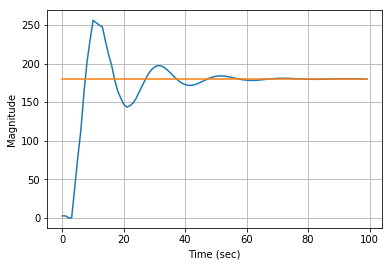

In [241]:
L=0 # punto de inicio
H=100 # punto final
t = np.linspace(0, len(y), num=len(y))
target = np.linspace(setPoint, setPoint, num=len(y))
plt.figure()
plt.plot(t[L:H],y[L:H], t[L:H], target[L:H])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

In [ ]:
d = {'pwm': [0], 'pwm1': [0], 'y1': [0], 'pwm2': [0], 'y2': [0], 'pwm3': [0], 'y3': [0], 'pwm4': [0], 'y4': [0]}
_y = model.predict(pd.DataFrame(data=d))
_y